# Treinamento do Naive Bayes

Classes:
- Acidente grave
- Acidente moderado
- NaoAcidente

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
diretorio = '/content/drive/MyDrive/IFCE - Eng. Computação/Probabilidade e Estatística/DatasetRaw/Acidentes'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import os
import pandas as pd
import cv2
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score, cross_val_predict
from skimage.feature import hog
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

## Carregando dados

In [ ]:
targets = [x[0].replace(diretorio, '') for x in os.walk(diretorio)]
targets = targets[1:len(targets)]

dados = []

for classe in targets:
    imagens = os.listdir(diretorio + classe)

    for img in imagens:

        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img):
            dados.append([diretorio + classe + '/' + img, classe])

dados = np.array(dados)

df_dados = pd.DataFrame(dados, columns=['image', 'target'])
df_dados

,image,target
0,/content/drive/MyDrive/IFCE - Eng. Computação/...,/Moderado
1,/content/drive/MyDrive/IFCE - Eng. Computação/...,/Moderado
2,/content/drive/MyDrive/IFCE - Eng. Computação/...,/Moderado
3,/content/drive/MyDrive/IFCE - Eng. Computação/...,/Moderado
4,/content/drive/MyDrive/IFCE - Eng. Computação/...,/Moderado
...,...,...
145,/content/drive/MyDrive/IFCE - Eng. Computação/...,/NaoAcidente
146,/content/drive/MyDrive/IFCE - Eng. Computação/...,/NaoAcidente
147,/content/drive/MyDrive/IFCE - Eng. Computação/...,/NaoAcidente
148,/content/drive/MyDrive/IFCE - Eng. Computação/...,/NaoAcidente


## Tratando imagens

In [ ]:
def tratar(img_path, largura, altura, modo_de_cor):
  img = image.load_img(img_path, target_size=(largura, altura), color_mode=modo_de_cor)
  embed = image.img_to_array(img)
  embed = embed / 255.0

  return embed.flatten()

In [ ]:
target = df_dados['target'].array

largura = 64
altura = 64
modo_de_cor = 'rgb'

array_features = []
for x in dados:
    array_features.append(tratar(x[0], largura, altura, modo_de_cor))

scaler = StandardScaler()
array_features = scaler.fit_transform(array_features)

df_features = pd.DataFrame(array_features)
df_features

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,1.783755,1.685255,1.557901,1.807550,1.707691,1.552413,1.739264,1.640423,1.501441,1.853025,...,-0.816361,-1.536691,-1.489208,-1.337252,-1.613314,-1.592131,-1.453546,-1.704099,-1.673683,-1.524937
1,-1.566698,-1.038504,-0.397724,-1.586598,-1.009516,-0.418918,-1.671669,-1.082586,-0.540310,-1.617753,...,0.427785,-0.511716,-0.361465,-0.077145,0.145435,0.447021,0.517364,-0.618210,-0.381976,-0.344881
2,1.429001,1.333382,1.231963,1.501411,1.399830,1.270795,1.351354,1.251421,1.146885,1.297701,...,1.012158,0.430600,0.607689,0.774759,0.314545,0.502134,0.706874,0.226371,0.393048,0.606777
3,0.798328,0.616604,0.652519,-1.000941,-1.156754,-0.394430,1.578749,1.533112,1.391406,1.242168,...,1.803887,1.455575,1.612085,1.733150,1.413763,1.567637,1.654427,1.450150,1.574037,1.710701
4,-1.369613,-1.364312,-1.266891,-1.546667,-1.638623,-1.484172,-1.471026,-1.471587,-1.310551,-1.215142,...,-0.835212,-0.445589,-0.467191,-0.804812,-0.784672,-0.857301,-0.998721,-0.652683,-0.695677,-0.839743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.626087,1.685255,1.557901,1.634515,1.600609,1.491192,0.776177,0.795351,0.792330,-1.353974,...,-0.948316,-0.329866,-0.308602,-0.396608,-0.209697,-0.048989,0.024636,-0.807810,-0.732582,-0.953942
146,-0.778356,-0.686631,-0.747805,-0.481836,-0.433950,-0.529117,-0.641701,-0.572860,-0.625892,-1.034662,...,1.049859,0.827364,1.030592,1.165215,0.804966,1.034885,1.218553,0.898588,1.131166,1.253905
147,-1.001720,-1.051536,-1.097886,-1.014251,-1.116598,-1.116843,-0.962730,-1.055758,-1.212743,-0.132260,...,1.408022,1.323320,1.330149,1.378190,1.227742,1.310446,1.389112,1.226078,1.334149,1.406170
148,-0.147683,0.121375,0.193792,-0.748044,-0.581188,-0.749514,-0.013020,0.071004,-0.234659,0.214818,...,1.841589,1.472107,1.700190,1.804142,1.312297,1.567637,1.730231,1.243314,1.500226,1.653601


## Treinado o modelo

In [ ]:
def getModel():
  return GaussianNB()

In [ ]:
porcentagem_testes = 0.2
X_treino, X_teste, y_treino, y_teste = train_test_split(df_features.values, target, test_size=porcentagem_testes)

model = getModel().fit(X_treino, y_treino)
score = model.score(X_teste, y_teste)

score

0.6

## Relatório de Classificação para o Modelo com Features Básicas

In [ ]:
y_pred = model.predict(X_teste)
report = classification_report(y_teste, y_pred)
print("Classification Report para o Modelo com Features Básicas:")
print(report)

Classification Report para o Modelo com Features Básicas:
              precision    recall  f1-score   support

      /Grave       0.64      0.64      0.64        14
   /Moderado       0.50      0.83      0.62         6
/NaoAcidente       0.33      0.20      0.25        10

    accuracy                           0.53        30
   macro avg       0.49      0.56      0.51        30
weighted avg       0.51      0.53      0.51        30



## Gráficos

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

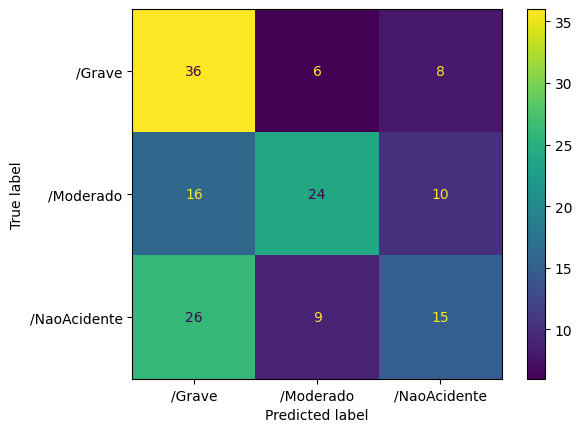

In [ ]:
predicoes = cross_val_predict(getModel(), df_features.values, target, cv=10)

# Gera a matriz de confusão comparando os rótulos verdadeiros e as predições
cm = confusion_matrix(target, predicoes)

# Cria uma visualização da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

# Plota a matriz de confusão
disp.plot()

# Exibe o gráfico
plt.show()

# Versão 2

## Tratando imagens

In [ ]:
def tratar_avancado(img_path):
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    img = cv2.resize(img, (128, 128))

    features_hog = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

    bordas = cv2.Canny(img, 100, 200)
    features_bordas = np.array([np.sum(bordas > 0) / bordas.size])

    return np.hstack([features_hog, features_bordas])

## Tratando imagens com a função `tratar_avancado`

In [ ]:
array_features_avancado = []
for x in dados:
    features = tratar_avancado(x[0])
    if features is not None:
        array_features_avancado.append(features)

scaler_avancado = StandardScaler()
array_features_avancado = scaler_avancado.fit_transform(array_features_avancado)

df_features_avancado = pd.DataFrame(array_features_avancado)
df_features_avancado

,0,1,2,3,4,5,6,7,8,9,...,8091,8092,8093,8094,8095,8096,8097,8098,8099,8100
0,-1.263768,-0.652029,2.204947,0.306969,1.270842,-1.088357,-0.908563,-0.771159,-1.170684,-1.720597,...,0.334376,-0.731305,-0.911035,-1.139599,-2.311146,-1.424077,-1.336910,-1.114353,0.249030,-0.242796
1,-1.153220,-0.855553,-0.589332,-0.755256,-1.534434,-1.189735,-1.123303,-0.701653,-0.468203,-0.449004,...,0.144506,-0.501804,1.012247,0.979833,0.515748,0.383036,0.414952,0.875442,-0.034451,-0.457959
2,0.430816,-0.965943,-0.732759,-0.846819,4.618939,-0.903076,-0.942112,-0.939960,-1.142604,-1.535970,...,1.227776,-0.109757,2.161150,0.615056,-0.722286,-0.128848,0.739343,-0.656401,0.572286,-0.469065
3,1.975448,-0.234136,3.453719,-0.335366,1.611617,-0.200266,-0.012996,-0.376076,-0.977123,-1.346219,...,-0.108341,-0.934050,-0.758517,-0.240900,-1.580578,0.290371,-0.154832,-0.466135,-0.468013,1.135635
4,1.397720,-0.249950,-0.170718,-0.584635,1.074417,0.699659,2.384632,2.678520,-0.779753,-1.357527,...,0.616873,1.635809,0.590294,0.696867,-0.968234,-1.203372,0.471967,0.435070,0.094807,-1.009054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.554575,-0.405004,-0.868125,-1.024766,-1.202400,-1.022008,-1.042672,-1.067448,2.155945,1.221606,...,1.457930,2.186434,-0.483024,-0.975268,-1.471832,-0.853238,-0.874309,-0.340985,2.535033,0.399916
146,-0.433811,-0.626292,-0.251025,-0.760002,-0.667239,0.433801,0.169999,0.243803,-0.483223,-0.931467,...,-1.957485,-0.862754,-1.217529,-0.957859,1.657576,-0.762634,-0.834293,-1.258873,-1.176329,2.383580
147,0.725727,-0.184354,-0.723565,-0.462665,-0.902857,-0.196142,-0.501860,0.325999,-0.256926,0.785839,...,-0.969307,-0.846163,-0.706473,-0.004109,1.421899,2.346564,-1.176001,-0.951517,-1.076707,0.248608
148,1.482925,1.607960,1.701607,-0.303690,0.566390,1.215228,-0.105200,-0.369931,-1.059309,1.227626,...,0.637853,-0.228316,1.012863,-0.942902,0.311192,0.609372,1.399109,1.469500,0.402978,0.269430


## Treinando o modelo com as features avançadas

## Relatório de Classificação para o Modelo com Features Avançadas

In [ ]:
porcentagem_testes_avancado = 0.2
X_treino_avancado, X_teste_avancado, y_treino_avancado, y_teste_avancado = train_test_split(df_features_avancado.values, target, test_size=porcentagem_testes_avancado)

model_avancado = getModel().fit(X_treino_avancado, y_treino_avancado)
score_avancado = model_avancado.score(X_teste_avancado, y_teste_avancado)

print(f"Score do modelo com features avançadas: {score_avancado}")

Score do modelo com features avançadas: 0.6666666666666666


In [ ]:
y_pred_avancado = model_avancado.predict(X_teste_avancado)
report_avancado = classification_report(y_teste_avancado, y_pred_avancado)
print("Classification Report para o Modelo com Features Avançadas:")
print(report_avancado)

Classification Report para o Modelo com Features Avançadas:
              precision    recall  f1-score   support

      /Grave       0.79      0.85      0.81        13
   /Moderado       0.43      0.43      0.43         7
/NaoAcidente       0.67      0.60      0.63        10

    accuracy                           0.67        30
   macro avg       0.63      0.62      0.62        30
weighted avg       0.66      0.67      0.66        30



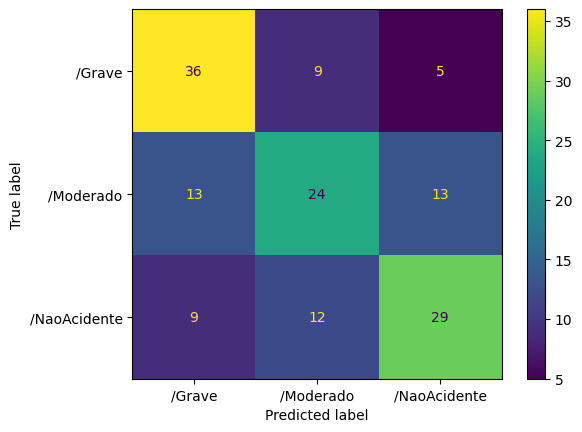

In [ ]:
predicoes = cross_val_predict(getModel(), df_features_avancado.values, target, cv=10)

# Gera a matriz de confusão comparando os rótulos verdadeiros e as predições
cm = confusion_matrix(target, predicoes)

# Cria uma visualização da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)

# Plota a matriz de confusão
disp.plot()

# Exibe o gráfico
plt.show()

# Deploy do modelo

In [ ]:
joblib.dump(model, 'modelo.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# Deploy modelo avançado

In [ ]:
joblib.dump(model_avancado, 'modelo_avancado.pkl')
joblib.dump(scaler_avancado, 'scaler_avancado.pkl')

['scaler_avancado.pkl']